# Import Libraries and Constants

In [166]:
%matplotlib inline
import torch as th
#import torch.nn.functional as F
import torch.nn as nn 
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
#from sklearn.model_selection import train_test_split,  RandomizedSearchCV, PredefinedSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_poisson_deviance, d2_tweedie_score, make_scorer, auc
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from skorch import NeuralNetRegressor, NeuralNet, callbacks
import utils
import architecture
import run_config

In [167]:
NUM_ROUNDS = run_config.server_config["num_rounds"]
NUM_ROUNDS

25

In [168]:
FL_PATH = '../ag_-1/fl_model.pt'

In [169]:
list(run_config.top_results_dict[-1].items())

[('param_module__num_units_1', 15), ('param_module__num_units_2', 15)]

In [170]:
FL_NUM_UNITS_1 = run_config.NUM_UNITS_1 #list(run_config.top_results_dict[-1].items())[0][1]
FL_NUM_UNITS_2 =run_config.NUM_UNITS_2 # list(run_config.top_results_dict[-1].items())[1][1]
FL_NUM_UNITS_1, FL_NUM_UNITS_2

(10, 15)

In [171]:
NUM_FEATURES = run_config.NUM_FEATURES
NUM_FEATURES

39

In [172]:
list(run_config.top_results_dict[-1].items())[1][1]

15

# Load Models

Get number of units from neural network

In [173]:
all_results_df = pd.read_csv('../results/all_results.csv')
all_results_df 

,params_key,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_optimizer__lr,param_module__num_units_2,param_module__num_units_1,params,split0_test_score,...,test_mean_poisson_deviance,test_weighted_mean_poisson_deviance,test_pde,test_weighted_pde,test_r^2,test_gini,test_min_pred,test_max_pred,test_mean_pred,test_var_pred
0,0.01_15_15,196.100577,0.0,0.169910,0.0,0.010,15,15,"{'optimizer__lr': 0.01, 'module__num_units_2':...",0.053161,...,0.297244,0.345576,0.069372,0.049287,0.027176,0.278167,0.006481,0.976513,0.056568,0.002330
1,0.001_15_10,196.644357,0.0,0.168628,0.0,0.001,15,10,"{'optimizer__lr': 0.001, 'module__num_units_2'...",0.053005,...,0.297244,0.345576,0.069372,0.049287,0.027176,0.278167,0.006481,0.976513,0.056568,0.002330
2,0.01_5_15,203.194840,0.0,0.183526,0.0,0.010,5,15,"{'optimizer__lr': 0.01, 'module__num_units_2':...",0.050264,...,0.297244,0.345576,0.069372,0.049287,0.027176,0.278167,0.006481,0.976513,0.056568,0.002330
3,0.001_5_15,203.093068,0.0,0.244930,0.0,0.001,5,15,"{'optimizer__lr': 0.001, 'module__num_units_2'...",0.050171,...,0.297244,0.345576,0.069372,0.049287,0.027176,0.278167,0.006481,0.976513,0.056568,0.002330
4,0.001_5_10,212.592985,0.0,0.171873,0.0,0.001,5,10,"{'optimizer__lr': 0.001, 'module__num_units_2'...",0.048527,...,0.297244,0.345576,0.069372,0.049287,0.027176,0.278167,0.006481,0.976513,0.056568,0.002330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,0.01_15_10,22.096757,0.0,0.017174,0.0,0.010,15,10,"{'optimizer__lr': 0.01, 'module__num_units_2':...",0.017023,...,0.302476,0.350637,0.052992,0.035365,0.019466,0.233904,0.004409,0.739774,0.055228,0.001792
194,0.01_10_10,18.705281,0.0,0.017029,0.0,0.010,10,10,"{'optimizer__lr': 0.01, 'module__num_units_2':...",0.016654,...,0.302476,0.350637,0.052992,0.035365,0.019466,0.233904,0.004409,0.739774,0.055228,0.001792
195,0.01_5_15,20.076639,0.0,0.019602,0.0,0.010,5,15,"{'optimizer__lr': 0.01, 'module__num_units_2':...",0.015535,...,0.302476,0.350637,0.052992,0.035365,0.019466,0.233904,0.004409,0.739774,0.055228,0.001792
196,0.01_10_15,19.670488,0.0,0.016914,0.0,0.010,10,15,"{'optimizer__lr': 0.01, 'module__num_units_2':...",0.005576,...,0.302476,0.350637,0.052992,0.035365,0.019466,0.233904,0.004409,0.739774,0.055228,0.001792


Filter to just best hyperparameters

In [174]:
top_results_df = all_results_df.loc[all_results_df['rank_test_score']==1]
top_results_df

,params_key,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_optimizer__lr,param_module__num_units_2,param_module__num_units_1,params,split0_test_score,...,test_mean_poisson_deviance,test_weighted_mean_poisson_deviance,test_pde,test_weighted_pde,test_r^2,test_gini,test_min_pred,test_max_pred,test_mean_pred,test_var_pred
0,0.01_15_15,196.100577,0.0,0.169910,0.0,0.010,15,15,"{'optimizer__lr': 0.01, 'module__num_units_2':...",0.053161,...,0.297244,0.345576,0.069372,0.049287,0.027176,0.278167,0.006481,0.976513,0.056568,0.002330
18,0.01_5_5,20.008427,0.0,0.020523,0.0,0.010,5,5,"{'optimizer__lr': 0.01, 'module__num_units_2':...",0.026619,...,0.303001,0.351762,0.051349,0.032270,0.017883,0.235008,0.006249,1.486323,0.054485,0.002135
36,0.001_5_5,18.939121,0.0,0.020901,0.0,0.001,5,5,"{'optimizer__lr': 0.001, 'module__num_units_2'...",0.043688,...,0.305757,0.352718,0.042721,0.029639,0.015628,0.217477,0.011497,0.669419,0.055492,0.001171
54,0.01_15_5,21.280727,0.0,0.017167,0.0,0.010,15,5,"{'optimizer__lr': 0.01, 'module__num_units_2':...",0.035008,...,0.303516,0.351518,0.049735,0.032941,0.015083,0.241438,0.005212,0.563204,0.059091,0.002020
72,0.001_15_5,20.849439,0.0,0.017103,0.0,0.001,15,5,"{'optimizer__lr': 0.001, 'module__num_units_2'...",0.008715,...,0.305485,0.352423,0.043572,0.030450,0.016275,0.219599,0.010609,0.617047,0.050834,0.001082
90,0.001_10_15,19.882550,0.0,0.016873,0.0,0.001,10,15,"{'optimizer__lr': 0.001, 'module__num_units_2'...",0.040948,...,0.303954,0.352654,0.048365,0.029815,0.018569,0.222494,0.006691,0.400638,0.050524,0.001073
108,0.001_15_10,22.022524,0.0,0.017043,0.0,0.001,15,10,"{'optimizer__lr': 0.001, 'module__num_units_2'...",0.040161,...,0.305204,0.352181,0.044452,0.031115,0.015853,0.216518,0.006654,1.276634,0.055040,0.001441
126,0.001_15_15,18.382708,0.0,0.017310,0.0,0.001,15,15,"{'optimizer__lr': 0.001, 'module__num_units_2'...",0.048244,...,0.302535,0.350513,0.052808,0.035705,0.021203,0.238650,0.004387,0.832045,0.047203,0.001281
144,0.001_10_10,18.679389,0.0,0.017002,0.0,0.001,10,10,"{'optimizer__lr': 0.001, 'module__num_units_2'...",0.023029,...,0.301865,0.350347,0.054904,0.036161,0.021465,0.234919,0.007747,0.881464,0.053105,0.001376
162,0.001_10_15,20.461995,0.0,0.016970,0.0,0.001,10,15,"{'optimizer__lr': 0.001, 'module__num_units_2'...",0.065472,...,0.304065,0.351990,0.048017,0.031643,0.017751,0.226526,0.005943,1.074375,0.054855,0.001609


In [175]:
top_results_df[['agent', 'param_module__num_units_1', 'param_module__num_units_2']]

,agent,param_module__num_units_1,param_module__num_units_2
0,-1,15,15
18,0,5,5
36,1,5,5
54,2,5,15
72,3,5,15
90,4,15,10
108,5,10,15
126,6,15,15
144,7,10,10
162,8,15,10


Create dictionary to lookup hyperparameters

In [176]:
top_results_dict = top_results_df[['agent', 'param_module__num_units_1', 'param_module__num_units_2']].set_index('agent').to_dict('index')
top_results_dict

{-1: {'param_module__num_units_1': 15, 'param_module__num_units_2': 15},
 0: {'param_module__num_units_1': 5, 'param_module__num_units_2': 5},
 1: {'param_module__num_units_1': 5, 'param_module__num_units_2': 5},
 2: {'param_module__num_units_1': 5, 'param_module__num_units_2': 15},
 3: {'param_module__num_units_1': 5, 'param_module__num_units_2': 15},
 4: {'param_module__num_units_1': 15, 'param_module__num_units_2': 10},
 5: {'param_module__num_units_1': 10, 'param_module__num_units_2': 15},
 6: {'param_module__num_units_1': 15, 'param_module__num_units_2': 15},
 7: {'param_module__num_units_1': 10, 'param_module__num_units_2': 10},
 8: {'param_module__num_units_1': 15, 'param_module__num_units_2': 10},
 9: {'param_module__num_units_1': 10, 'param_module__num_units_2': 15}}

In [177]:
tuning_results_df = pd.read_csv('../results/all_results.csv')
top_results_df = tuning_results_df.loc[tuning_results_df['rank_test_score']==1]
top_results_dict = top_results_df[['agent', 'param_module__num_units_1', 'param_module__num_units_2']].set_index('agent').to_dict('index')
list(top_results_dict[-1].items())[1][1]

15

In [178]:
NUM_UNITS_1 = list(top_results_dict[-1].items())[0][1]
NUM_UNITS_1

15

Use dictionary to access results, for example to lookup `agent=0`:

In [179]:
top_results_dict[-1]

{'param_module__num_units_1': 15, 'param_module__num_units_2': 15}

In [180]:
list(top_results_dict[-1].items())[0][1]

15

In [181]:
list(top_results_dict[-1].items())[1][1]

15

## Create load model function

In [182]:
def load_model(agent=-1, num_features=NUM_FEATURES):

    num_units_1 = list(top_results_dict[agent].items())[0][1]
    num_units_2 = list(top_results_dict[agent].items())[1][1]
    print(num_units_1)
    print(num_units_2)
    #num_units_3 = list(top_results_dict[agent].items())[2][1]

    loaded_agent_model = NeuralNetRegressor(architecture.MultipleRegression(num_features, num_units_1, num_units_2).double())
    loaded_agent_model.initialize()  # This is important!
    loaded_agent_model.load_params(f_params=f'../ag_'+str(agent)+'/agent_'+str(agent)+'_model.pkl', 
                                       f_optimizer=f'../ag_'+str(agent)+'/agent_'+str(agent)+'_opt.pkl', 
                                       f_history=f'../ag_'+str(agent)+'/agent_'+str(agent)+'_history.json')
    
    return loaded_agent_model

## Loop through

In [183]:
NUM_AGENTS = 10

In [184]:
agent_model_dictionary = {}
for agents in range(NUM_AGENTS):
    agent_model_dictionary["loaded_agent_{0}_model".format(agents)] = eval('load_model(agent='+str(agents)+')')

5
5
5
5
5
15
5
15
15
10
10
15
15
15
10
10
15
10
10
15


## Load Federated Model

In [185]:
fl_model = architecture.MultipleRegression(num_features=NUM_FEATURES, num_units_1=FL_NUM_UNITS_1, num_units_2=FL_NUM_UNITS_2)
fl_model

MultipleRegression(
  (layer_1): Linear(in_features=39, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=15, bias=True)
  (layer_out): Linear(in_features=15, out_features=1, bias=True)
  (dropout): Dropout(p=0, inplace=False)
  (act): Tanh()
)

In [186]:
fl_model.load_state_dict(th.load(FL_PATH))
fl_model.eval()

MultipleRegression(
  (layer_1): Linear(in_features=39, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=15, bias=True)
  (layer_out): Linear(in_features=15, out_features=1, bias=True)
  (dropout): Dropout(p=0, inplace=False)
  (act): Tanh()
)

Again can lookup each agent's model

In [187]:
agent_model_dictionary['loaded_agent_0_model']

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=MultipleRegression(
    (layer_1): Linear(in_features=39, out_features=5, bias=True)
    (layer_2): Linear(in_features=5, out_features=5, bias=True)
    (layer_out): Linear(in_features=5, out_features=1, bias=True)
    (dropout): Dropout(p=0, inplace=False)
    (act): Tanh()
  ),
)

## Load global model

In [188]:
loaded_agent_global_model = load_model(agent=0)

5
5


# Load Test Data and Functions

In [189]:
def frequency_conversion(FACTOR, df, freq_dictionary):
      for key in freq_dictionary:
            df[freq_dictionary[key]]=df[key]/df['Exposure']

      df.insert(1,FACTOR+'_binned_midpoint',[round((a.left + a.right)/2,0) for a in df[FACTOR+'_binned']])

In [190]:
def undummify(df, prefix_sep="_"):
    cols2collapse = {
        item.split(prefix_sep)[0]: (prefix_sep in item) for item in df.columns
    }
    series_list = []
    for col, needs_to_collapse in cols2collapse.items():
        if needs_to_collapse:
            undummified = (
                df.filter(like=col)
                .idxmax(axis=1)
                .apply(lambda x: x.split(prefix_sep, maxsplit=1)[1])
                .rename(col)
            )
            series_list.append(undummified)
        else:
            series_list.append(df[col])
    undummified_df = pd.concat(series_list, axis=1)
    return undummified_df

In [191]:
def create_test_data(): 
    (X_train, X_val, X_test, y_train, y_val, y_test, X_column_names, scaler) = utils.upload_dataset()
    
    MY_DATA_PATH = '../data'
    
    X_test_sc = pd.read_csv(MY_DATA_PATH + '/X_test.csv')
    y_te = pd.read_csv(MY_DATA_PATH + '/y_test.csv')
    X_column_names = X_test_sc.columns.tolist()

    test_complete_data=np.column_stack((X_test_sc, y_te))

    X_column_names.append('ClaimNb')

    #Convert dataset of test data, actuals, and prediction back into dataframe

    df_test=pd.DataFrame(data=test_complete_data,    # values
                    columns=X_column_names)  # 1st row as the column names
    
    # Un one-hot encode Region and VehBrand
    df_test = undummify(df_test)
    df_test['VehBrand_number'] = df_test['VehBrand'].str[1:].astype(int)
    df_test['Region_number'] = df_test['Region'].str[1:].astype(int)


    df_test[['Area', 'VehPower', 'VehAge','DrivAge','BonusMalus','Density']]=scaler.inverse_transform(df_test[['Area', 'VehPower', 'VehAge','DrivAge','BonusMalus','Density']] )
    
    #Bin factors
    factor_list = ['Area', 'VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'VehGas', 'Density', 'VehBrand_number', 'Region_number']
    
    # If fewer levels than MAX_BINSIZE no effective binning happens via the min() function, not used currently
    MAX_BINSIZE = 20

    # Automatic binning not used, could use qcut as well 
    for i in factor_list:
        df_test[i+'_binned'] = pd.cut(df_test[i], bins=min(len(df_test[i].unique()), MAX_BINSIZE), duplicates='drop')
        #df_test[i+'_binned'] = pd.cut(df_test[i], bins=np.linspace(0, max(df_test[i]), min(21, len(df_test[i].unique()))), duplicates='drop')
    
    # Custom binning used instead to define more sensible bins
    df_test['Area'+'_binned'] = pd.cut(df_test['Area'], bins=np.linspace(0, 7, 8), duplicates='drop')
    df_test['VehPower'+'_binned'] = pd.cut(df_test['VehPower'], bins=np.linspace(0, 15, 16), duplicates='drop')
    df_test['VehAge'+'_binned'] = pd.cut(df_test['VehAge'], bins=np.linspace(0, 20, 21), duplicates='drop')
    df_test['DrivAge'+'_binned'] = pd.cut(df_test['DrivAge'], bins=np.linspace(0, 100, 21), duplicates='drop')
    df_test['BonusMalus'+'_binned'] = pd.qcut(df_test['BonusMalus'], q=15, duplicates='drop') # note usin qcut here
    df_test['Density'+'_binned'] = pd.cut(df_test['Density'], bins=np.linspace(0, 11, 12), duplicates='drop')
    df_test['VehBrand_number'+'_binned'] = pd.cut(df_test['VehBrand_number'], bins=np.linspace(0, 15, 16), duplicates='drop')
    df_test['Region_number'+'_binned'] = pd.cut(df_test['Region_number'], bins=np.linspace(0, 100, 21), duplicates='drop')
    df_test['VehGas'+'_binned'] = pd.cut(df_test['VehGas'], bins=np.linspace(0, 2, 3), duplicates='drop')
    
    return X_test, y_test, df_test

In [192]:
X_test, y_test, df_test = create_test_data()

In [193]:
def create_df_test_pred(df_test, X_test, global_model, NUM_AGENTS):
    
    # Global Model Predictions
    y_pred = global_model.predict(X_test.astype(np.float64))
    df_test['ClaimNb_pred']=pd.Series(y_pred.flatten())

    # FL Model Predictions
    y_fl_pred = fl_model.predict(th.tensor(X_test).float())
    df_test['ClaimNb_fl_pred']=pd.Series(y_fl_pred.flatten().detach().numpy())

    # Local Model Predictions

    agent_prediction_dictionary = {}

    for agents in range(NUM_AGENTS):
        agent_prediction_dictionary["y_agent_{0}_pred".format(agents)] = agent_model_dictionary['loaded_agent_'+str(agents)+'_model'].predict(X_test.astype(np.float64))
        df_test['ClaimNb_agent_'+str(agents)+'_pred']=pd.Series(agent_prediction_dictionary['y_agent_'+str(agents)+'_pred'].flatten())

    return df_test

In [194]:
df_test_pred = create_df_test_pred(df_test, X_test, loaded_agent_global_model, NUM_AGENTS)
#df_test_pred = create_df_test_pred(df_test, X_test, loaded_agent_global_model, 1)

In [195]:
df_test_pred['ClaimNb_pred_binned'] = pd.qcut(df_test_pred['ClaimNb_pred'], 25, duplicates='drop')
#df_test_pred['ClaimNb_pred_binned'] = pd.cut(df_test_pred['ClaimNb_pred'], bins=np.linspace(0, 0.65, 20), duplicates='drop')
#df_test_pred['ClaimNb_pred_binned'] = pd.cut(df_test_pred['ClaimNb_pred'], bins=[0,
                                                                                 #0.015,
                                                                                 #0.02,
                                                                                 #0.0225,
                                                                                 #0.025,
                                                                                 #0.0275,
                                                                                 #0.03,
                                                                                 #0.0325,
                                                                                 #0.035,
                                                                                 #0.0375,
                                                                                 #0.04,
                                                                                 #0.0425,
                                                                                 #0.045,
                                                                                 #0.0475,
                                                                                 #0.05,
                                                                                 #0.0535,
                                                                                 #0.0585,
                                                                                 #0.065,
                                                                                 #0.0725,
                                                                                 #0.085,
                                                                                 #0.155,
                                                                                 #10,
                                                                                #], duplicates='drop')
df_test_pred

,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehGas,Density,VehBrand,Region,...,ClaimNb_agent_1_pred,ClaimNb_agent_2_pred,ClaimNb_agent_3_pred,ClaimNb_agent_4_pred,ClaimNb_agent_5_pred,ClaimNb_agent_6_pred,ClaimNb_agent_7_pred,ClaimNb_agent_8_pred,ClaimNb_agent_9_pred,ClaimNb_pred_binned
0,1.000000,1.0,4.0,11.0,45.0,50.0,1.0,2.197225,B3,R24,...,0.052577,0.036820,0.041828,0.043729,0.061786,0.046772,0.040016,0.045476,0.063892,"(0.0489, 0.0512]"
1,0.700000,3.0,7.0,3.0,26.0,68.0,1.0,5.774552,B6,R31,...,0.055640,0.083537,0.046269,0.032662,0.040650,0.052117,0.049329,0.023521,0.044631,"(0.0445, 0.0468]"
2,0.460000,4.0,9.0,15.0,21.0,95.0,1.0,6.960348,B3,R24,...,0.078138,0.062252,0.058295,0.069646,0.056607,0.061737,0.067615,0.079991,0.074125,"(0.0752, 0.0873]"
3,0.450000,5.0,4.0,0.0,69.0,50.0,1.0,8.325548,B12,R52,...,0.074427,0.218363,0.058297,0.139868,0.052145,0.108216,0.187609,0.124488,0.161739,"(0.16, 1.486]"
4,0.490000,6.0,9.0,1.0,57.0,50.0,1.0,10.060320,B2,R21,...,0.055601,0.074162,0.055117,0.050011,0.053408,0.041946,0.051632,0.054994,0.045075,"(0.0561, 0.059]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135598,0.070000,3.0,9.0,0.0,53.0,50.0,1.0,5.953243,B12,R82,...,0.075801,0.113316,0.075370,0.127634,0.087444,0.105202,0.115014,0.109993,0.197946,"(0.11, 0.16]"
135599,0.110000,3.0,9.0,16.0,37.0,50.0,1.0,6.003887,B14,R24,...,0.022497,0.012267,0.014976,0.010815,0.013859,0.018753,0.015273,0.014233,0.014617,"(0.011, 0.0141]"
135600,0.008219,4.0,7.0,0.0,56.0,50.0,1.0,6.628041,B12,R26,...,0.107084,0.086946,0.032158,0.141392,0.030198,0.100177,0.173002,0.210044,0.126871,"(0.0873, 0.11]"
135601,0.280000,5.0,5.0,17.0,50.0,90.0,1.0,9.138522,B5,R82,...,0.070213,0.103938,0.063235,0.079371,0.062121,0.042957,0.061669,0.053844,0.062858,"(0.0678, 0.0752]"


In [196]:
sum_list = ['Exposure',  'ClaimNb', 'ClaimNb_pred', 'ClaimNb_fl_pred', 
            'ClaimNb_agent_0_pred', 
            # 'ClaimNb_agent_7_pred'
            ]
#sum_dictionary = {'ClaimNb':'Actual freq', 'ClaimNb_pred':'Freq pred global model', 'ClaimNb_fl_pred':'Freq pred FL model', 'ClaimNb_fl_pred':'Freq pred FL model'}
df_sum=df_test_pred.groupby(['ClaimNb_pred_binned'])[sum_list].sum().reset_index()
#df_sum['ClaimNb_freq']=df_sum['ClaimNb']/df_sum['Exposure']
#df_sum['ClaimNb_pred_freq']=df_sum['ClaimNb_pred']/df_sum['Exposure']
#df_sum['ClaimNb_fl_pred_freq']=df_sum['ClaimNb_fl_pred']/df_sum['Exposure']
#df_sum['ClaimNb_agent_0_pred_freq']=df_sum['ClaimNb_agent_0_pred']/df_sum['Exposure']
df_sum['ClaimNb_rebased'] = df_sum['ClaimNb']/df_sum['ClaimNb']
df_sum['ClaimNb_pred_rebased'] = df_sum['ClaimNb_pred']/df_sum['ClaimNb']
df_sum['ClaimNb_fl_pred_rebased'] = df_sum['ClaimNb_fl_pred']/df_sum['ClaimNb']
df_sum['ClaimNb_agent_0_pred_rebased'] = df_sum['ClaimNb_agent_0_pred']/df_sum['ClaimNb']
df_sum

,ClaimNb_pred_binned,Exposure,ClaimNb,ClaimNb_pred,ClaimNb_fl_pred,ClaimNb_agent_0_pred,ClaimNb_rebased,ClaimNb_pred_rebased,ClaimNb_fl_pred_rebased,ClaimNb_agent_0_pred_rebased
0,"(0.00525, 0.011]",640.036489,80.0,49.668992,94.642387,49.668992,1.0,0.620862,1.183030,0.620862
1,"(0.011, 0.0141]",838.301020,123.0,68.092241,111.187790,68.092241,1.0,0.553595,0.903966,0.553595
2,"(0.0141, 0.0171]",988.397488,127.0,84.260487,121.840164,84.260487,1.0,0.663468,0.959371,0.663468
3,"(0.0171, 0.0203]",1117.034654,124.0,101.319335,134.950867,101.319335,1.0,0.817091,1.088313,0.817091
4,"(0.0203, 0.0238]",1275.281478,126.0,119.501331,144.946304,119.501331,1.0,0.948423,1.150367,0.948423
5,"(0.0238, 0.0272]",1558.924916,145.0,138.295595,162.825119,138.295595,1.0,0.953763,1.122932,0.953763
6,"(0.0272, 0.0305]",1779.900487,200.0,156.444543,174.260406,156.444543,1.0,0.782223,0.871302,0.782223
7,"(0.0305, 0.0337]",2045.874495,192.0,174.254315,188.330124,174.254315,1.0,0.907575,0.980886,0.907575
8,"(0.0337, 0.0368]",2232.322368,195.0,191.431309,197.711563,191.431309,1.0,0.981699,1.013905,0.981699
9,"(0.0368, 0.0394]",2407.676099,210.0,206.828066,205.169617,206.828066,1.0,0.984896,0.976998,0.984896


FixedFormatter should only be used together with FixedLocator


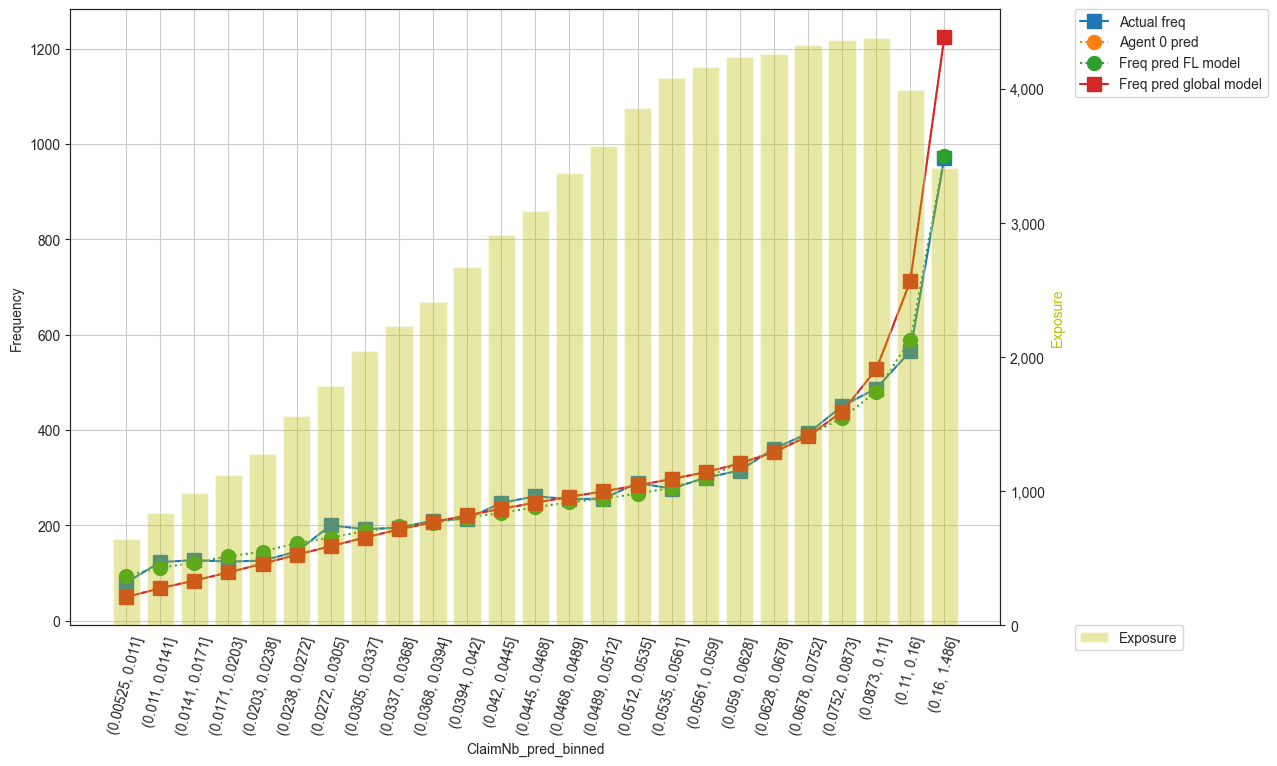

In [197]:
fig, ax = plt.subplots(figsize=(12, 8))

plt.plot(df_sum['ClaimNb'],  
        label='Actual freq',
        marker='s',
        markersize=10,
        )

#for agents in range(NUM_AGENTS):
        #plt.plot(df_sum['Freq pred agent '+str(agents)+' model'],  
        #label='Freq pred agent '+str(agents)+' model',
        #marker='o',
        #markersize=5,
        #linestyle=(0, (1, 10)),
        #linestyle='dotted',
        #)
plt.plot(df_sum['ClaimNb_agent_0_pred'],  
        label='Agent 0 pred',
        marker='o',
        markersize=10,
        linestyle='dotted',
        )

#plt.plot(df_sum['ClaimNb_agent_7_pred'],  
        #label='Agent 7 pred',
        #marker='o',
        #markersize=10,
        #linestyle='dotted',
        #)

plt.plot(df_sum['ClaimNb_fl_pred'],  
        label='Freq pred FL model',
        marker='o',
        markersize=10,
        linestyle='dotted',
        )

plt.plot(df_sum['ClaimNb_pred'],  
        label='Freq pred global model',
        marker='s',
        markersize=10,
        #linestyle='dotted',
        )

plt.legend(bbox_to_anchor=(1.08, 1), loc='upper left', borderaxespad=0)

plt.xlabel('ClaimNb_pred_binned')
plt.xticks(rotation = 75)
plt.ylabel('Frequency')
plt.grid()


# Get second axis
ax2 = ax.twinx()

plt.bar(df_sum['ClaimNb_pred_binned'].astype(str), 
        df_sum['Exposure'], 
        label='Exposure', 
        color='y',
        alpha=0.35
        )

plt.ylabel('Exposure', color='y')
plt.xticks(rotation = 90)

vals = ax2.get_yticks()
ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])

plt.legend(bbox_to_anchor=(1.08, 0), loc='upper left', borderaxespad=0)

plt.show()

FixedFormatter should only be used together with FixedLocator


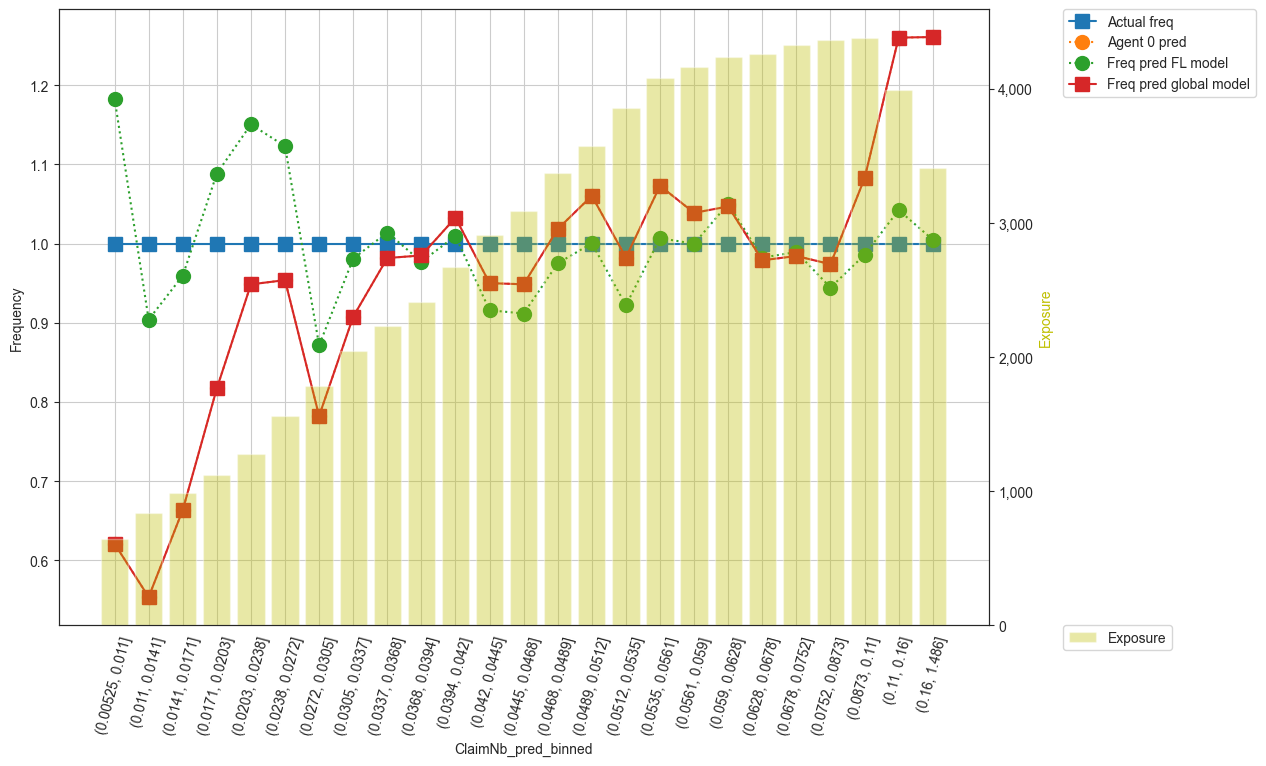

In [198]:
fig, ax = plt.subplots(figsize=(12, 8))

plt.plot(df_sum['ClaimNb_rebased'],  
        label='Actual freq',
        marker='s',
        markersize=10,
        )

#for agents in range(NUM_AGENTS):
        #plt.plot(df_sum['Freq pred agent '+str(agents)+' model'],  
        #label='Freq pred agent '+str(agents)+' model',
        #marker='o',
        #markersize=5,
        #linestyle=(0, (1, 10)),
        #linestyle='dotted',
        #)
plt.plot(df_sum['ClaimNb_agent_0_pred_rebased'],  
        label='Agent 0 pred',
        marker='o',
        markersize=10,
        linestyle='dotted',
        )

#plt.plot(df_sum['ClaimNb_agent_7_pred'],  
        #label='Agent 7 pred',
        #marker='o',
        #markersize=10,
        #linestyle='dotted',
        #)

plt.plot(df_sum['ClaimNb_fl_pred_rebased'],  
        label='Freq pred FL model',
        marker='o',
        markersize=10,
        linestyle='dotted',
        )

plt.plot(df_sum['ClaimNb_pred_rebased'],  
        label='Freq pred global model',
        marker='s',
        markersize=10,
        #linestyle='dotted',
        )

plt.legend(bbox_to_anchor=(1.08, 1), loc='upper left', borderaxespad=0)

plt.xlabel('ClaimNb_pred_binned')
plt.xticks(rotation = 75)
plt.ylabel('Frequency')
plt.grid()


# Get second axis
ax2 = ax.twinx()

plt.bar(df_sum['ClaimNb_pred_binned'].astype(str), 
        df_sum['Exposure'], 
        label='Exposure', 
        color='y',
        alpha=0.35
        )

plt.ylabel('Exposure', color='y')
plt.xticks(rotation = 90)

vals = ax2.get_yticks()
ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])

plt.legend(bbox_to_anchor=(1.08, 0), loc='upper left', borderaxespad=0)

plt.show()

In [199]:
def create_df_sum(df_test_pred, factor, NUM_AGENTS):

    sum_list = ['Exposure',  'ClaimNb', 'ClaimNb_pred', 'ClaimNb_fl_pred']
    sum_dictionary = {'ClaimNb':'Actual freq', 'ClaimNb_pred':'Freq pred global model', 'ClaimNb_fl_pred':'Freq pred FL model'}

    for agents in range(NUM_AGENTS):
        sum_list.append('ClaimNb_agent_'+str(agents)+'_pred')
        sum_dictionary['ClaimNb_agent_'+str(agents)+'_pred']='Freq pred agent '+str(agents)+' model'

    df_sum=df_test_pred.groupby([factor+'_binned'])[sum_list].sum().reset_index()

    frequency_conversion(factor, df_sum, sum_dictionary)

    # Remove rows with 0 exposure
    df_sum = df_sum.loc[df_sum['Exposure']!=0]
    df_sum = df_sum.reset_index(drop=True)

    return df_sum

In [200]:
def one_way_graph_comparison(factor, NUM_AGENTS):

        df_sum = create_df_sum(df_test_pred, factor, NUM_AGENTS)
        
        fig, ax = plt.subplots(figsize=(12, 8))

        plt.plot(df_sum['Actual freq'],  
                label='Actual freq',
                marker='s',
                markersize=10,
                )
        
        for agents in range(NUM_AGENTS):
                plt.plot(df_sum['Freq pred agent '+str(agents)+' model'],  
                label='Freq pred agent '+str(agents)+' model',
                marker='o',
                markersize=5,
                linestyle=(0, (1, 10)),
                #linestyle='dotted',
                )


        plt.plot(df_sum['Freq pred FL model'],  
                label='Freq pred FL model',
                marker='o',
                markersize=10,
                #linestyle='dotted',
                )
        
        plt.plot(df_sum['Freq pred global model'],  
                label='Freq pred global model',
                marker='s',
                markersize=10,
                #linestyle='dotted',
                )

        plt.legend(bbox_to_anchor=(1.08, 1), loc='upper left', borderaxespad=0)

        plt.xlabel(factor+'_binned')
        plt.xticks(rotation = 75)
        plt.ylabel('Frequency')
        plt.grid()


        # Get second axis
        ax2 = ax.twinx()

        plt.bar(df_sum[factor+'_binned'].astype(str), 
                df_sum['Exposure'], 
                label='Exposure', 
                color='y',
                alpha=0.35
                )

        plt.ylabel('Exposure', color='y')
        plt.xticks(rotation = 90)

        vals = ax2.get_yticks()
        ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])

        plt.legend(bbox_to_anchor=(1.08, 0), loc='upper left', borderaxespad=0)

        plt.show()

# One Way AvE Graphs

FixedFormatter should only be used together with FixedLocator


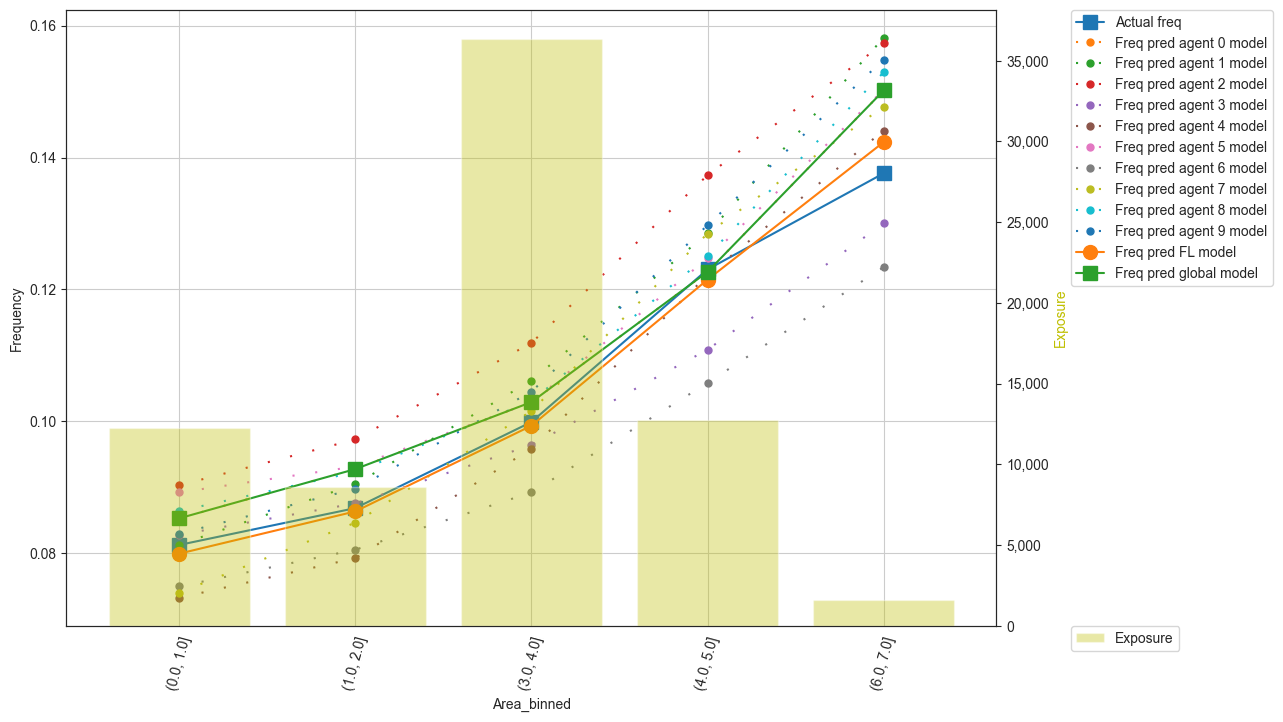

FixedFormatter should only be used together with FixedLocator


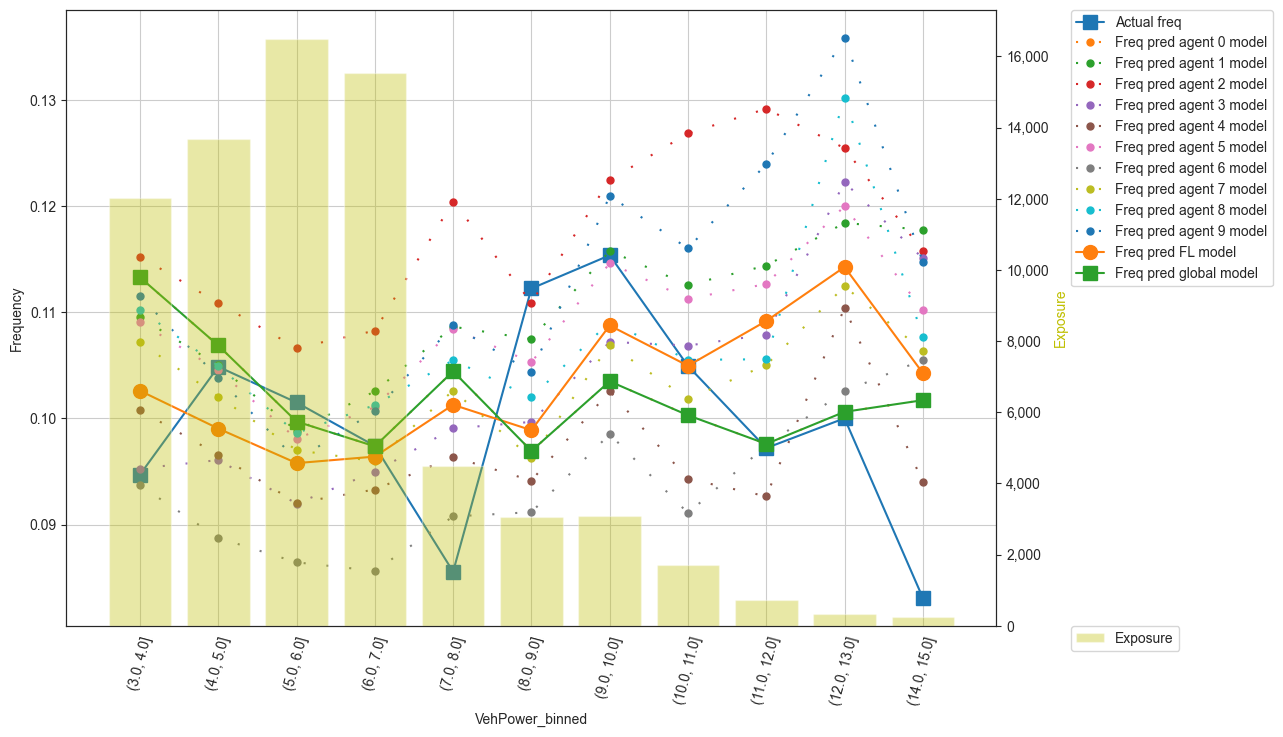

FixedFormatter should only be used together with FixedLocator


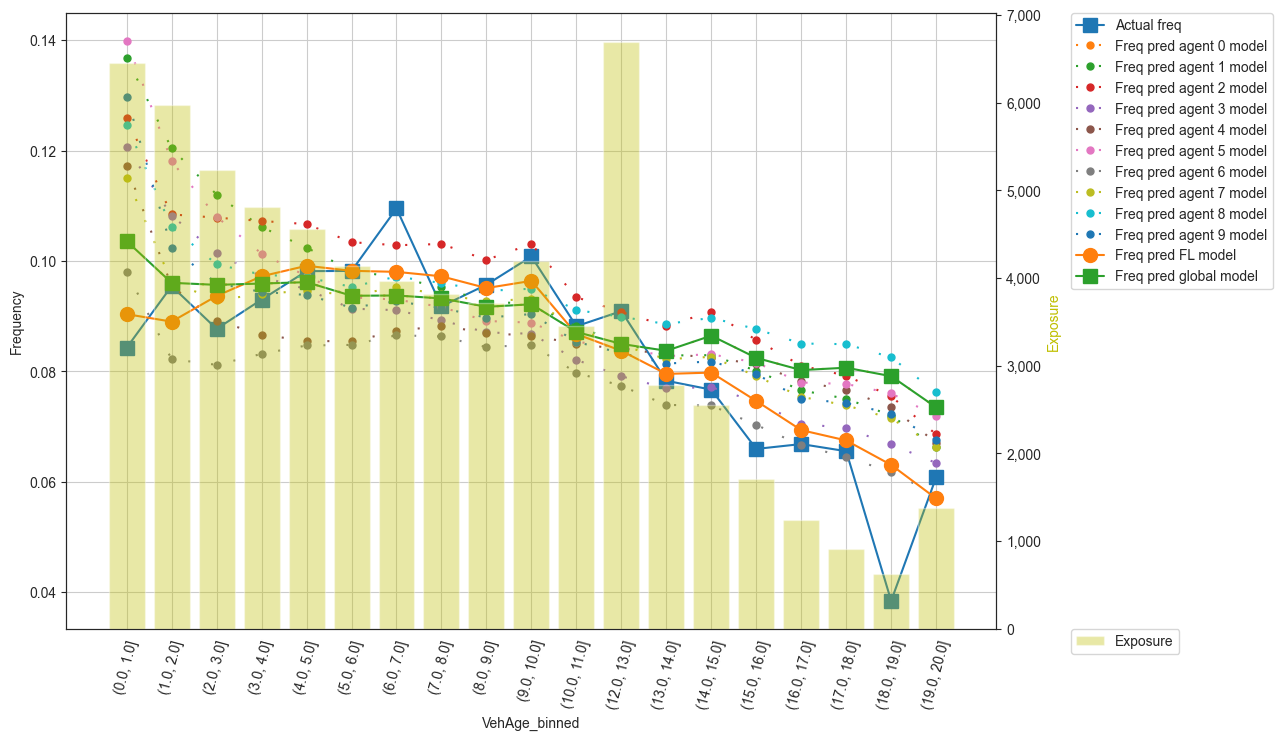

FixedFormatter should only be used together with FixedLocator


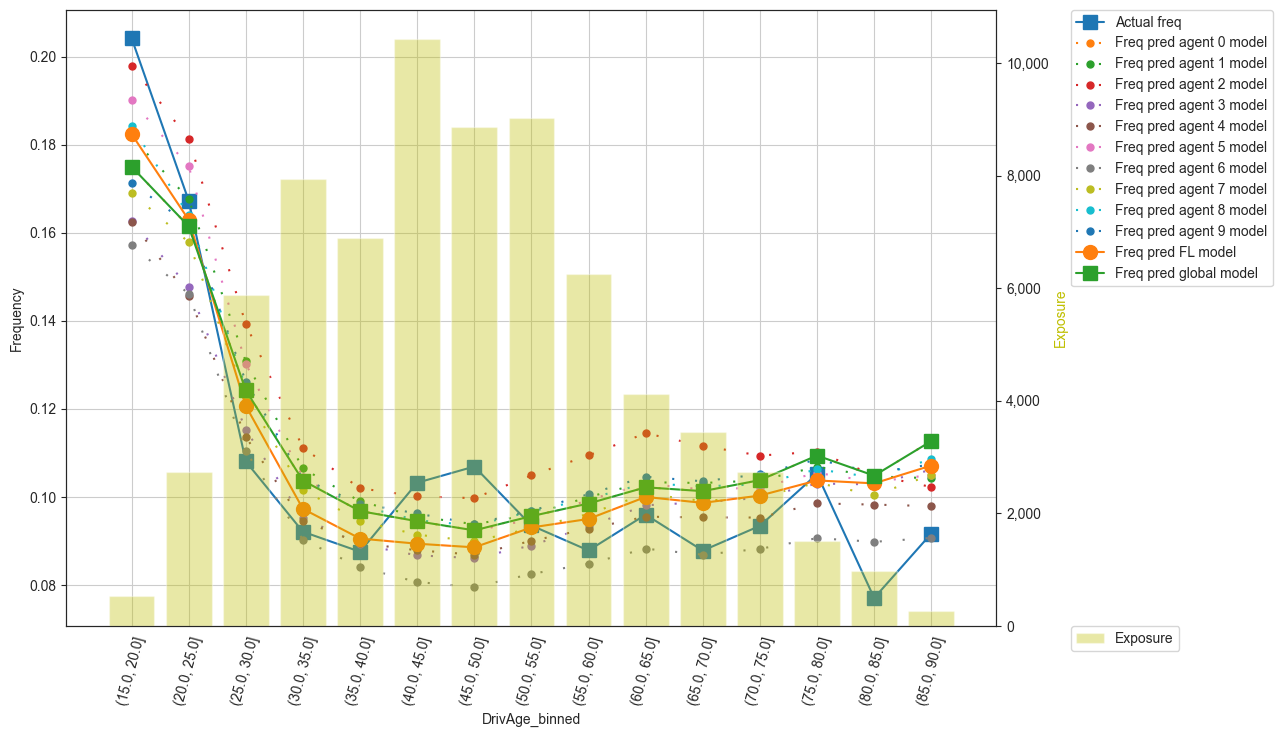

FixedFormatter should only be used together with FixedLocator


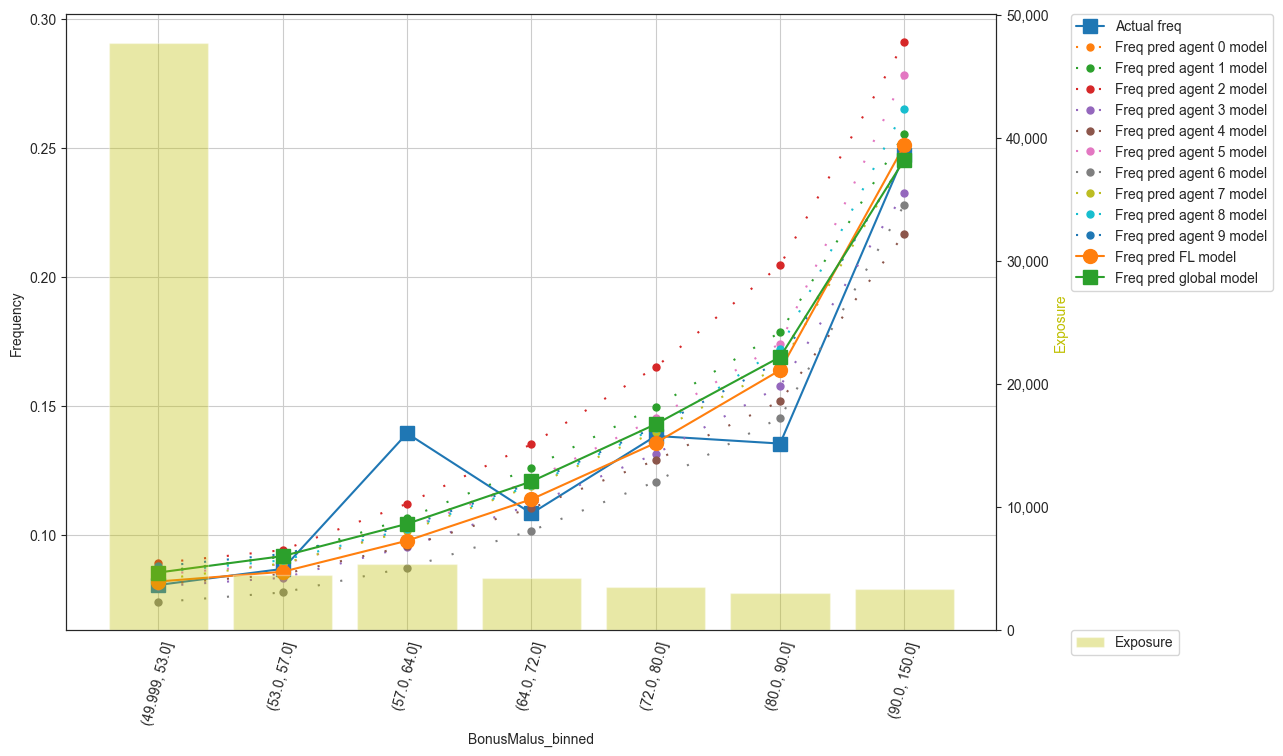

FixedFormatter should only be used together with FixedLocator


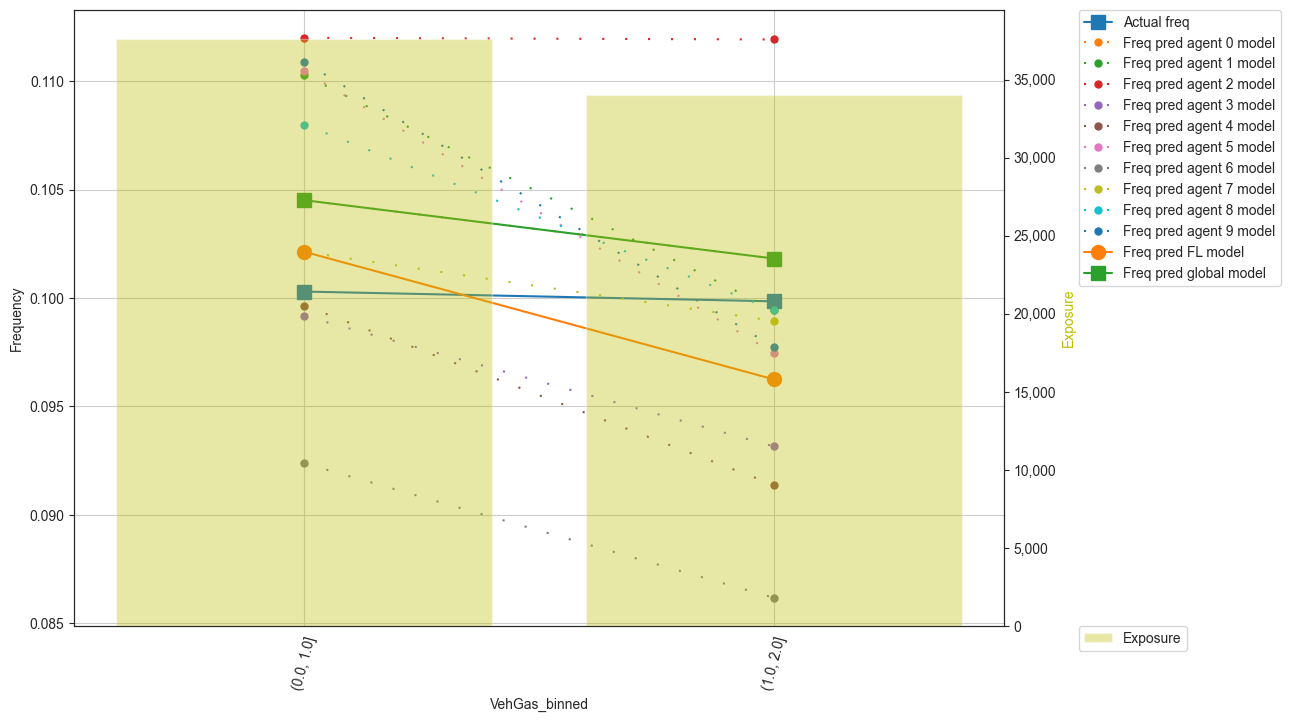

FixedFormatter should only be used together with FixedLocator


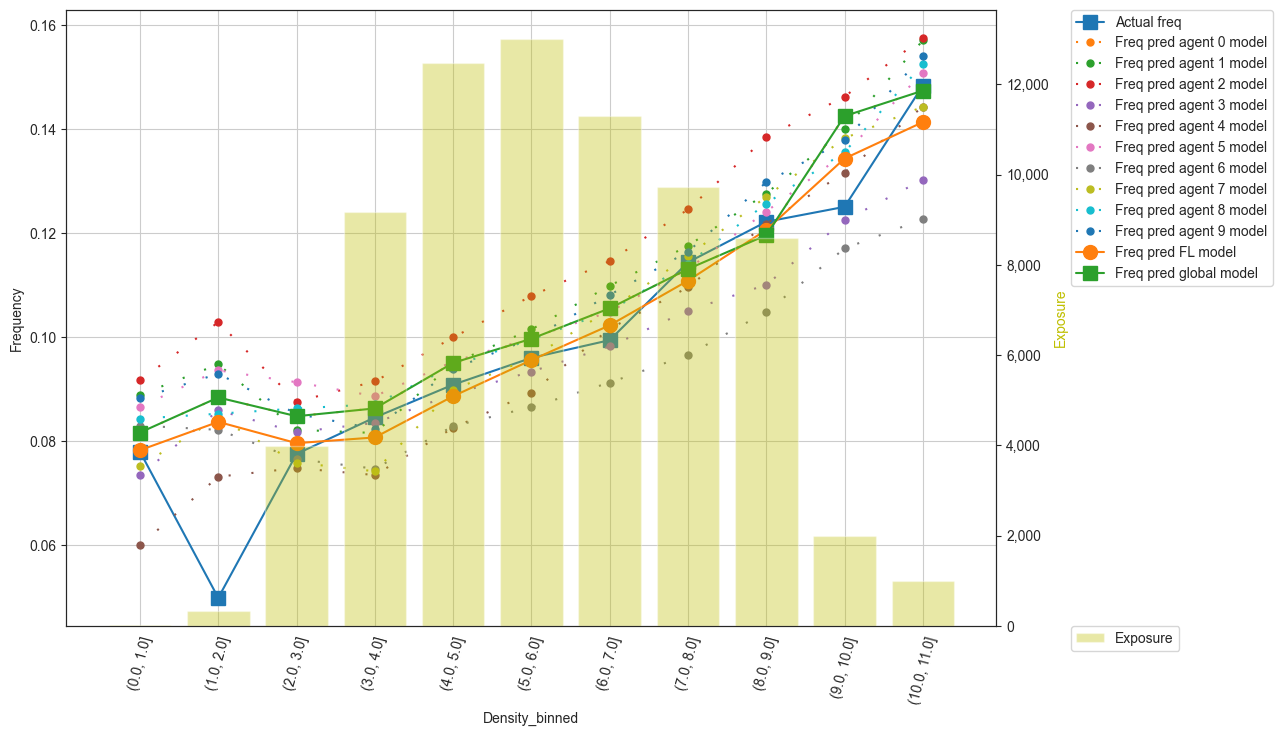

FixedFormatter should only be used together with FixedLocator


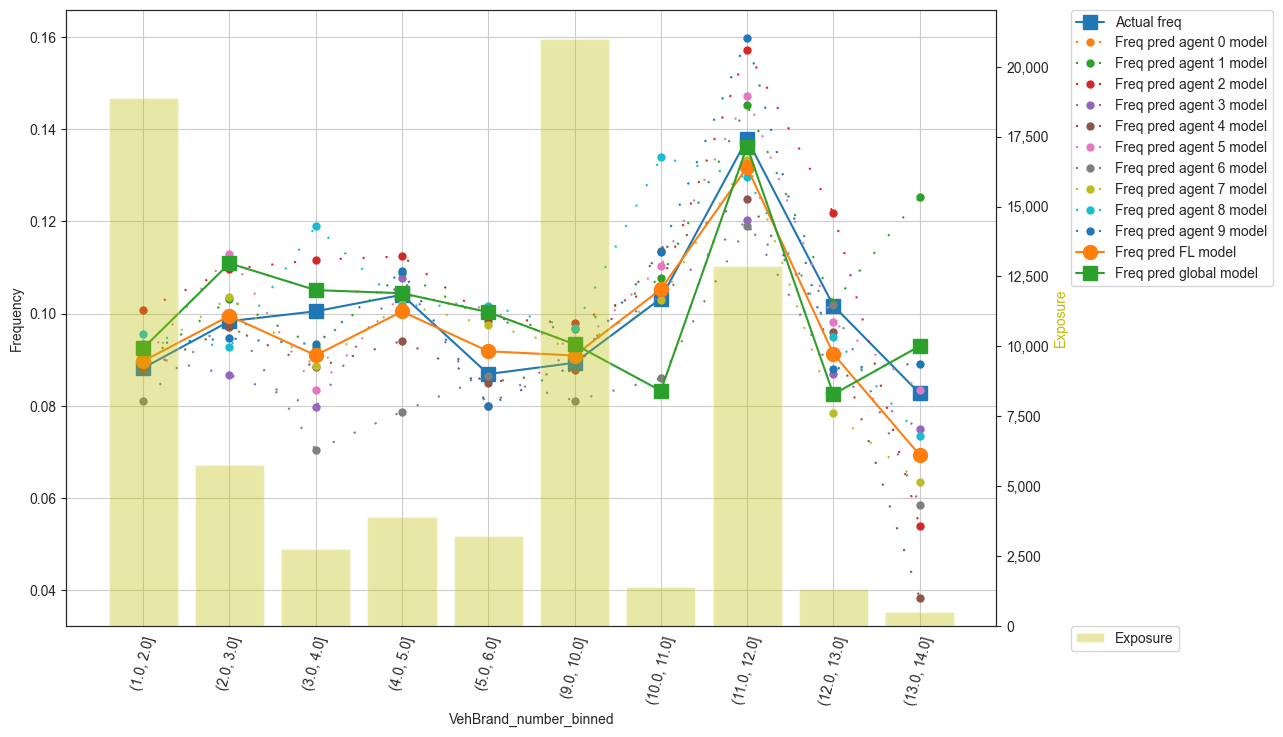

FixedFormatter should only be used together with FixedLocator


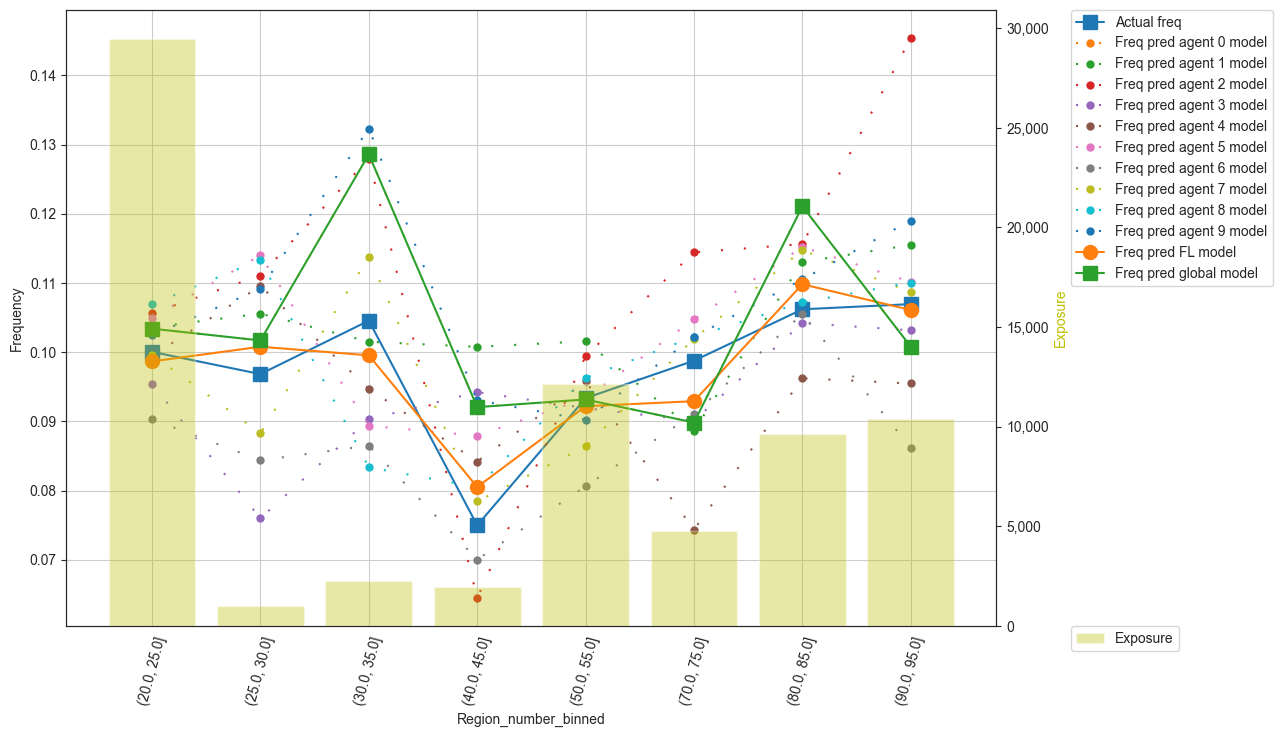

In [201]:
for i in ['Area', 'VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'VehGas', 'Density', 'VehBrand_number', 'Region_number']:
    one_way_graph_comparison(i, NUM_AGENTS)

# Gini

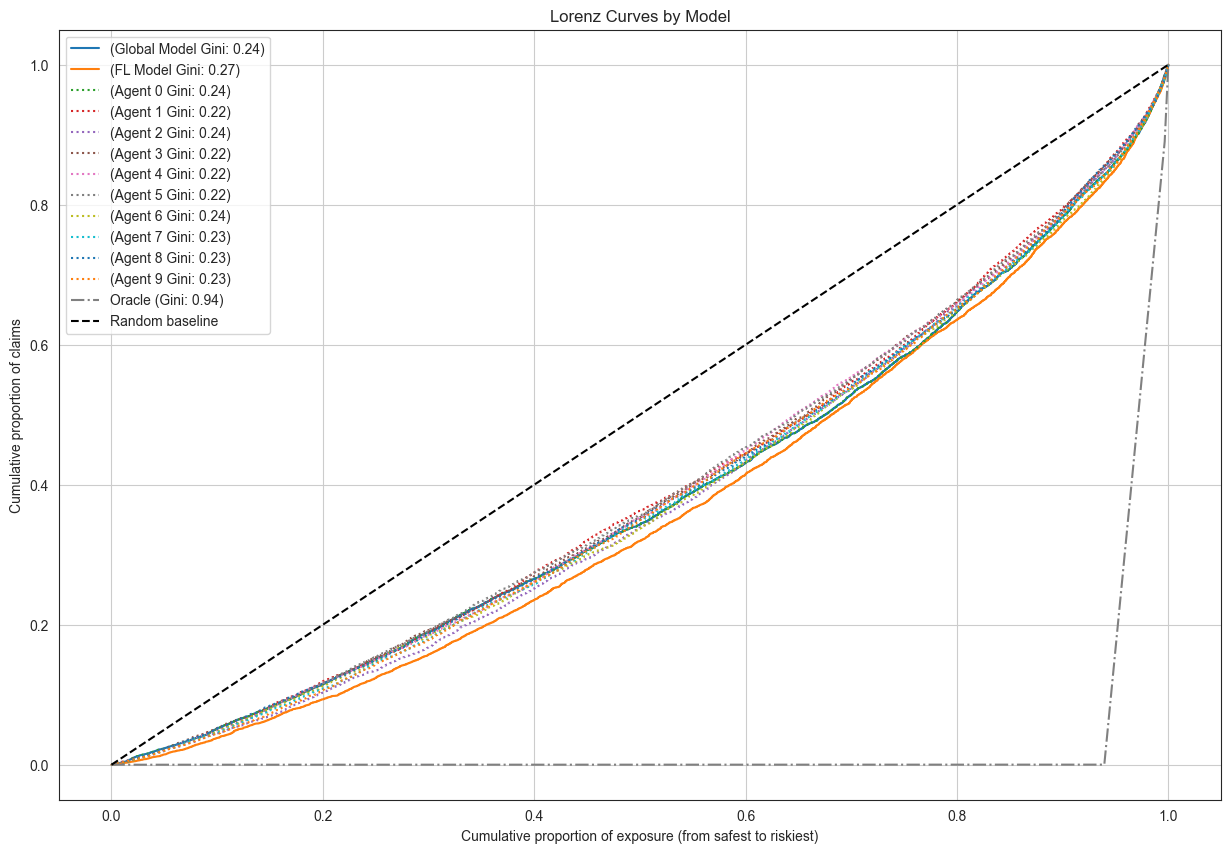

In [202]:
fig, ax = plt.subplots(figsize=(15, 10))

cum_exposure, cum_claims = utils.lorenz_curve(
    df_test_pred['ClaimNb'], df_test_pred['ClaimNb_pred'], df_test_pred["Exposure"]
)
gini = 1 - 2 * auc(cum_exposure, cum_claims)
label = "(Global Model Gini: {:.2f})".format(gini)
ax.plot(cum_exposure, cum_claims, linestyle="-", label=label)

cum_exposure, cum_claims = utils.lorenz_curve(
    df_test_pred['ClaimNb'], df_test_pred['ClaimNb_fl_pred'], df_test_pred["Exposure"]
)
gini = 1 - 2 * auc(cum_exposure, cum_claims)
label = "(FL Model Gini: {:.2f})".format(gini)
ax.plot(cum_exposure, cum_claims, linestyle="-", label=label)

for agents in range(NUM_AGENTS):
    cum_exposure, cum_claims = utils.lorenz_curve(
        df_test_pred['ClaimNb'], df_test_pred['ClaimNb_agent_'+str(agents)+'_pred'], df_test_pred["Exposure"]
    )
    gini = 1 - 2 * auc(cum_exposure, cum_claims)
    label = '(Agent {} Gini: {:.2f})'.format(agents, gini)
    plt.plot(cum_exposure, cum_claims, linestyle="dotted", label=label)

# Oracle model: y_pred == y_test
cum_exposure, cum_claims = utils.lorenz_curve(
    df_test_pred['ClaimNb'], df_test_pred['ClaimNb'], df_test_pred["Exposure"]
)
gini = 1 - 2 * auc(cum_exposure, cum_claims)
label = "Oracle (Gini: {:.2f})".format(gini)
ax.plot(cum_exposure, cum_claims, linestyle="-.", color="gray", label=label)

# Random Baseline
ax.plot([0, 1], [0, 1], linestyle="--", color="black", label="Random baseline")
ax.set(
    title="Lorenz Curves by Model",
    xlabel="Cumulative proportion of exposure (from safest to riskiest)",
    ylabel="Cumulative proportion of claims",
)

plt.grid()
ax.legend(loc="upper left")

#plt.savefig(f'../ag_{ag}/' + 'lift_chart')

# Metric comparison

In [203]:
y_fl_pred = df_test['ClaimNb_fl_pred']

In [204]:
fl_weighted_pde = d2_tweedie_score(y_test, y_fl_pred, sample_weight=X_test[:, 0], power=1)
fl_weighted_pde 

0.04737715494164885

In [205]:
y_global_pred = df_test['ClaimNb_pred']
global_weighted_pde = d2_tweedie_score(y_test, y_global_pred, sample_weight=X_test[:, 0], power=1)
global_weighted_pde 

0.03226960460056261

In [206]:
weighted_pde_df = top_results_df[['agent', 'test_weighted_pde']]
weighted_pde_df

,agent,test_weighted_pde
0,-1,0.049287
18,0,0.032270
36,1,0.029639
54,2,0.032941
72,3,0.030450
90,4,0.029815
108,5,0.031115
126,6,0.035705
144,7,0.036161
162,8,0.031643


In [207]:
weighted_pde_df.loc[151] = [-2, d2_tweedie_score(y_test, y_fl_pred, sample_weight=X_test[:, 0], power=1)]
weighted_pde_df


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,agent,test_weighted_pde
0,-1.0,0.049287
18,0.0,0.032270
36,1.0,0.029639
54,2.0,0.032941
72,3.0,0.030450
90,4.0,0.029815
108,5.0,0.031115
126,6.0,0.035705
144,7.0,0.036161
162,8.0,0.031643


In [208]:
weighted_pde_df['fl_relative_increase'] = fl_weighted_pde/weighted_pde_df['test_weighted_pde'] - 1
weighted_pde_df


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,agent,test_weighted_pde,fl_relative_increase
0,-1.0,0.049287,-0.038748
18,0.0,0.032270,0.468167
36,1.0,0.029639,0.598477
54,2.0,0.032941,0.438260
72,3.0,0.030450,0.555887
90,4.0,0.029815,0.589043
108,5.0,0.031115,0.522623
126,6.0,0.035705,0.326895
144,7.0,0.036161,0.310156
162,8.0,0.031643,0.497254


In [209]:
weighted_pde_df['model'] = 'Agent'+' '+weighted_pde_df['agent'].astype(int).apply(str)
weighted_pde_df


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,agent,test_weighted_pde,fl_relative_increase,model
0,-1.0,0.049287,-0.038748,Agent -1
18,0.0,0.032270,0.468167,Agent 0
36,1.0,0.029639,0.598477,Agent 1
54,2.0,0.032941,0.438260,Agent 2
72,3.0,0.030450,0.555887,Agent 3
90,4.0,0.029815,0.589043,Agent 4
108,5.0,0.031115,0.522623,Agent 5
126,6.0,0.035705,0.326895,Agent 6
144,7.0,0.036161,0.310156,Agent 7
162,8.0,0.031643,0.497254,Agent 8


In [210]:
weighted_pde_df['model'] = weighted_pde_df['model'].str.replace('Agent -1','Global Model')
weighted_pde_df['model'] = weighted_pde_df['model'].str.replace('Agent -2','Federated Model')
weighted_pde_df


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,agent,test_weighted_pde,fl_relative_increase,model
0,-1.0,0.049287,-0.038748,Global Model
18,0.0,0.032270,0.468167,Agent 0
36,1.0,0.029639,0.598477,Agent 1
54,2.0,0.032941,0.438260,Agent 2
72,3.0,0.030450,0.555887,Agent 3
90,4.0,0.029815,0.589043,Agent 4
108,5.0,0.031115,0.522623,Agent 5
126,6.0,0.035705,0.326895,Agent 6
144,7.0,0.036161,0.310156,Agent 7
162,8.0,0.031643,0.497254,Agent 8


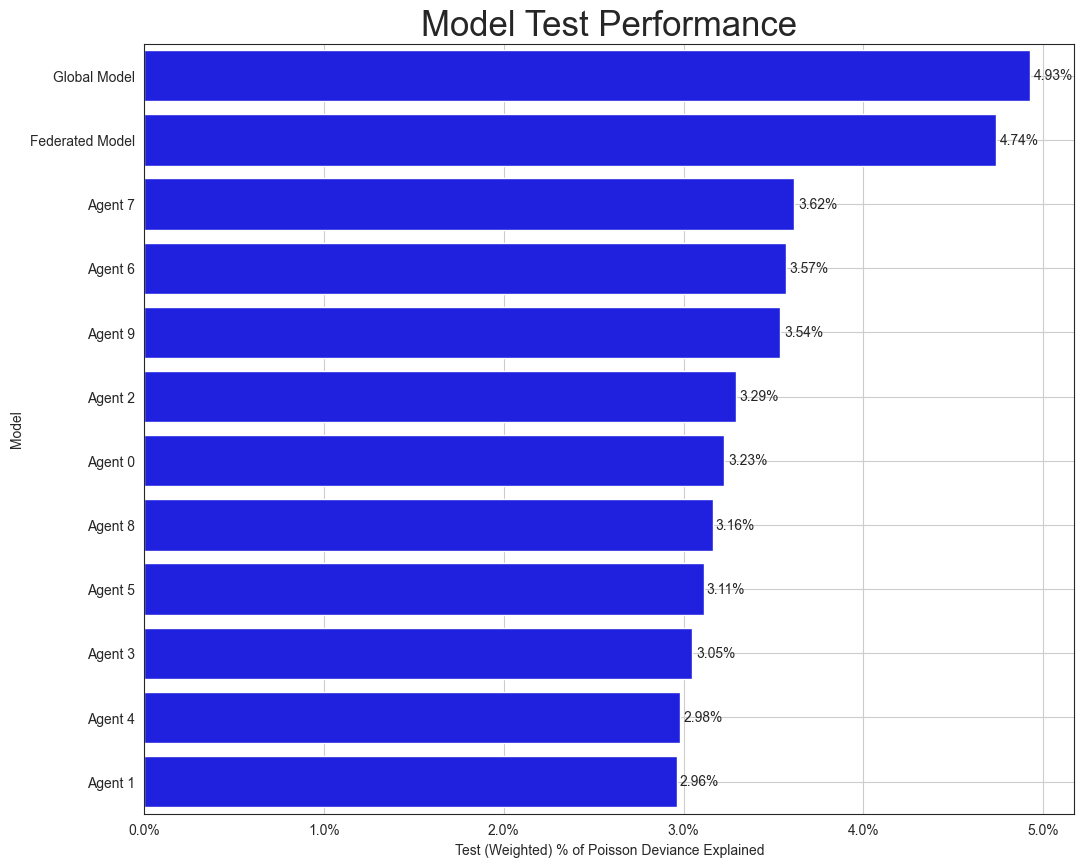

In [211]:
fig, ax = plt.subplots(figsize=(12,10))

sns.set_style('white')

ax=sns.barplot(y='model', 
               x='test_weighted_pde',
               data=weighted_pde_df.iloc[0:,:].sort_values(by=['test_weighted_pde'], ascending = False),
               orient='h',
               color='blue',
               )
plt.title('Model Test Performance', fontsize=25)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('Test (Weighted) % of Poisson Deviance Explained', fontsize=10)
plt.ylabel('Model', fontsize=10)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1))
#ax.axvline(global_weighted_pde, ls='--')
#ax.annotate('Global Model Test Performance', xy=(global_weighted_pde, -0.5), horizontalalignment='center', weight='semibold', size='medium')
for i in range(12):
    ax.text(round(weighted_pde_df.sort_values(by=['test_weighted_pde'], ascending=False).reset_index(drop=True).iloc[0+i:1+i,1],4).tolist()[0]+0.0002, 
            i, 
            '{:.2%}'.format(round(weighted_pde_df.sort_values(by=['test_weighted_pde'], ascending=False).reset_index(drop=True).iloc[0+i:1+i,1],4).tolist()[0]),
            verticalalignment='center',
            fontdict=(dict(fontsize=10)))
ax.grid(True)
plt.show()

# SHAP

In [212]:
import shap

In [213]:
background = X_test[np.random.choice(X_test.shape[0], 100, replace=False)]

In [214]:
# Define architecture (OPTUNA ARCHITECTURE)
class MultipleRegression(nn.Module):
    def __init__(self, num_features=39, 
                 num_units_1=40, 
                 num_units_2=60, 
                 #num_units_3=60,
                 activation=nn.Tanh, 
                 dropout_rate=0):
        super(MultipleRegression, self).__init__()
        
        self.act1 = activation()
        self.act2 = activation()

        self.layers = nn.Sequential(
        nn.Linear(num_features, num_units_1),
        self.act1,
        nn.Linear(num_units_1, num_units_2),
        self.act2,
        nn.Linear(num_units_2, 1)
        )
    
    def forward(self, x):
        return th.exp(self.layers(x))

In [215]:
FL_PATH

'../ag_-1/fl_model.pt'

In [216]:
fl_model = architecture.MultipleRegression(num_features=NUM_FEATURES, num_units_1=FL_NUM_UNITS_1, num_units_2=FL_NUM_UNITS_2)
fl_model.load_state_dict(th.load(FL_PATH))
fl_model.eval()
fl_model

MultipleRegression(
  (layer_1): Linear(in_features=39, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=15, bias=True)
  (layer_out): Linear(in_features=15, out_features=1, bias=True)
  (dropout): Dropout(p=0, inplace=False)
  (act): Tanh()
)

In [217]:
list(run_config.top_results_dict[-1].items())[0][1]

15

In [218]:
type(fl_model)

architecture.MultipleRegression

In [219]:
e = shap.DeepExplainer(fl_model, th.from_numpy(background).float())

In [220]:
shap_values = e.shap_values(th.from_numpy(X_test).float())

RuntimeError: The size of tensor a (10) must match the size of tensor b (15) at non-singleton dimension 1

In [ ]:
shap_values

In [ ]:
shap_obj = e(th.from_numpy(X_test).float())

In [ ]:
shap.plots.beeswarm(shap_values)

# PDPs

In [ ]:
def plot_partial_dependency(bst, X, y, f_id):

    X_temp = X.copy()

    x_scan = np.linspace(np.percentile(X_temp[:, f_id], 0.1), np.percentile(X_temp[:, f_id], 99.5), 50)
    y_partial = []

    feature =  df_test.columns[f_id]

    for point in x_scan:

        X_temp[:, f_id] = point

        #dpartial = xgb.DMatrix(X_temp[:, feature_ids])

        # Global Model Predictions
        #y_pred = global_model.predict(X_test.astype(np.float64))
        
        #y_partial.append(np.average(bst.predict(X_temp)))
        y_partial.append(np.average(bst.predict(X_temp.astype(np.float64))))

    y_partial = np.array(y_partial)

    # Plot partial dependence

    fig, ax = plt.subplots()
    fig.set_size_inches(12, 10)
    plt.subplots_adjust(left = 0.17, right = 0.94, bottom = 0.15, top = 0.9)

    ax.plot(x_scan, y_partial, '-', color = 'black', linewidth = 1)
    #ax.plot(X[:, f_id], y, 'o', color = 'blue', alpha = 0.02)

    ax.set_xlim(min(x_scan), max(x_scan))
    ax.set_xlabel(feature, fontsize = 12)    
    ax.set_ylabel('Partial Dependence', fontsize = 12)

    #plt.title(bst, fontsize=25)

    ax.grid(True)
    
    plt.show()

In [ ]:
df_test

In [ ]:
for i in range(0,8):
    print('Feature '+str(i))
    plot_partial_dependency(loaded_agent_global_model, X_test, y_test, i)

In [ ]:
for i in range(0,8):
    print('Feature '+str(i))
    for j in range(0,10):
        print('Agent '+str(j))
        loaded_agent_j_model = load_model(agent=j)
        plot_partial_dependency(loaded_agent_j_model, X_test, y_test, i)

In [ ]:
X_temp = X_test.copy()

In [ ]:
X_temp[:, 4]

In [ ]:
x_scan = np.linspace(np.percentile(X_temp[:, 4], 0.1), np.percentile(X_temp[:, 4], 99.5), 50)
x_scan

In [ ]:
df_xscan = pd.DataFrame()
df_xscan['Area'] = pd.Series(x_scan)
df_xscan['VehPower'] = pd.Series(x_scan)
df_xscan['VehAge'] = pd.Series(x_scan)
df_xscan['DrivAge'] = pd.Series(x_scan)
df_xscan['BonusMalus'] = pd.Series(x_scan)
df_xscan['Density'] = pd.Series(x_scan)
df_xscan

In [ ]:
df_xscan[['Area_transform', 'VehPower_transform', 'VehAge_transform','DrivAge_transform','BonusMalus_transform','Density_transform']] = scaler.inverse_transform(df_xscan[['Area', 'VehPower', 'VehAge','DrivAge','BonusMalus','Density']])
df_xscan

In [ ]:
y_partial = []

for point in x_scan:

    X_temp[:, 4] = point

    #dpartial = xgb.DMatrix(X_temp[:, feature_ids])

    # Global Model Predictions
    #y_pred = global_model.predict(X_test.astype(np.float64))
    
    #y_partial.append(np.average(bst.predict(X_temp)))
    y_partial.append(np.average(loaded_agent_global_model.predict(X_temp.astype(np.float64))))

y_partial = np.array(y_partial)

    # Plot partial dependence

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(5, 5)
plt.subplots_adjust(left = 0.17, right = 0.94, bottom = 0.15, top = 0.9)

ax.plot(df_xscan['DrivAge_transform'], y_partial, '-', color = 'black', linewidth = 1)
#ax.plot(X[:, f_id], y, 'o', color = 'blue', alpha = 0.02)

#ax.set_xlim(min(x_scan), max(x_scan))
ax.set_xlabel('Feature X', fontsize = 10)    
ax.set_ylabel('Partial Dependence', fontsize = 12)

In [ ]:
'{:.2%}'.format(weighted_pde_df.sort_values(by=['test_weighted_pde'], ascending=False).reset_index(drop=True).iloc[1:2,1].tolist()[0])

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))

sns.set_style('white')

ax=sns.barplot(y='model', 
               x='fl_relative_increase',
               data=weighted_pde_df[~weighted_pde_df.agent.isin([-1, -2])].sort_values(by=['fl_relative_increase'], ascending = False),
               orient='h',
               color='blue',
               )
plt.title('Relative Increase in Model Performance', fontsize=25)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('Increase in % of Poisson Deviance Explained', fontsize=10)
plt.ylabel('Agent', fontsize=10)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.grid(True)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))

sns.set_style('white')

ax=sns.barplot(x='model', 
               y='fl_relative_increase',
               data=weighted_pde_df[~weighted_pde_df.agent.isin([-1, -2])],
               #orient='h',
               color='blue',
               )
plt.title('Relative Increase in Model Performance', fontsize=25)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.ylabel('Increase in % of Poisson Deviance Explained', fontsize=10)
plt.xlabel('Agent', fontsize=10)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.grid(True)
plt.show()

In [ ]:
import csv
import json

In [ ]:
def read_csv(filename):
    loss_stats_dict = dict()
    with open(filename) as f:
        file_data=csv.reader(f)
        headers=next(file_data)
        round = 0
        for i in file_data:
            loss_stats_dict[round] = dict(zip(headers,i))
            round +=1
    return loss_stats_dict

In [ ]:
loss_stats = dict()
for ag_id in range(-1, NUM_AGENTS):
    if ag_id == -1:
        MY_DATA_PATH = '../../../3agents/IFoA-FL-WP/ag_global'
    else:    
        MY_DATA_PATH = '../../../3agents/IFoA-FL-WP/ag_' + str(ag_id)
    
    loss_stats[ag_id] = read_csv(MY_DATA_PATH + '/los_stats.csv')

In [ ]:
for ag in range(0,10):
    loss_train_list = []
    loss_val_list = []
    for rnd_no in range(0, NUM_ROUNDS*2 +1):
                    if rnd_no % 2 != 0: # FIXED : TO_FIX !!!!!!!!    MS: -1 added temporarly!!!! I need to find out why some clients join from 2nd round ( ask Malgorzata if that is not clear :) 
                        y_train_loss = json.loads(loss_stats[ag][rnd_no]["train"])
                        loss_train_list.extend(y_train_loss)
                        y_val_loss = json.loads(loss_stats[ag][rnd_no]["val"])
                        loss_val_list.extend(y_val_loss)
    plt.figure(figsize=(20,8))
    plt.plot(loss_train_list[:], label='Train Loss')
    plt.plot(loss_val_list[:], label='Validation Loss')
    plt.xlabel('Epoch', fontsize=10)
    plt.ylabel('Loss', fontsize=10)
    plt.title(f'Agent {ag} Federated Local Loss Training Curve', fontsize=15)
    plt.legend()
    plt.grid()
    plt.show()